In [ ]:
os.listdir('data')

### Import libraries

In [1]:
import pandas as pd
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

### Read in the data

In [2]:
check=pd.read_csv('data/AAPL_processed.csv')
check=check.dropna()

### Function definitions

In [3]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    """
    Function to plot ACF, PACF, QQ and other statistical plots
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


def assign_trading_signals(df, forecasted_volatility):
    """
    Function to assign signal considering volatility
    """
    
    volatility_threshold = 0.02  # Example threshold, adjust as needed
    check['New_Signal']=2

    for i in range(1, len(df)):
        # ... (Your existing logic for buy_signals, sell_signals) ...
        buy_signals = 0
        sell_signals = 0

        # PPO rule
        if df['PPO'].iloc[i] > df['PPO_signal'].iloc[i] and df['PPO'].iloc[i-1] <= df['PPO_signal'].iloc[i-1]:
            buy_signals += 1
        elif df['PPO'].iloc[i] < df['PPO_signal'].iloc[i] and df['PPO'].iloc[i-1] >= df['PPO_signal'].iloc[i-1]:
            sell_signals += 1

        # CCI rule
        if df['CCI'].iloc[i] > -100 and df['CCI'].iloc[i-1] <= -100:
            buy_signals += 1
        elif df['CCI'].iloc[i] < 100 and df['CCI'].iloc[i-1] >= 100:
            sell_signals += 1

        # Bollinger Bands % rule
        if df['BB%'].iloc[i] > 0.2 and df['BB%'].iloc[i-1] <= 0.2:
            buy_signals += 1
        elif df['BB%'].iloc[i] < 0.8 and df['BB%'].iloc[i-1] >= 0.8:
            sell_signals += 1

        # RSI rule
        if df['RSI'].iloc[i] > 30 and df['RSI'].iloc[i-1] <= 30:
            buy_signals += 1
        elif df['RSI'].iloc[i] < 70 and df['RSI'].iloc[i-1] >= 70:
            sell_signals += 1
        
        # Incorporate volatility
        if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
            df.loc[i, 'New_Signal'] = 0 
        elif sell_signals > buy_signals:  # Keep sell logic as-is
            df.loc[i, 'New_Signal'] = 1 
    return df

### Finding the right p,d,q from best ARIMA models

In [4]:
TS=check.copy()
TS['date']=pd.to_datetime(TS['date'])
TS.set_index('date',inplace=True)
TS=TS['adj close']



# TS = TS['adj close']  # Assuming 'adjclose' is your target column

# Parameter ranges
p_values = range(0, 3)  # Adjust ranges as needed
d_values = range(0, 2)
q_values = range(0, 3)

best_aic = np.inf
best_order = None
best_model = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = smt.ARIMA(TS, order=(p, d, q)).fit()
                aic = model.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model
            except:
                continue

print("Best AIC: {:.2f} | Best Order: {}".format(best_aic, best_order,best_model))

/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, b

/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, b

Best AIC: 16969.53 | Best Order: (2, 1, 2)


/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
best_order

(2, 1, 2)

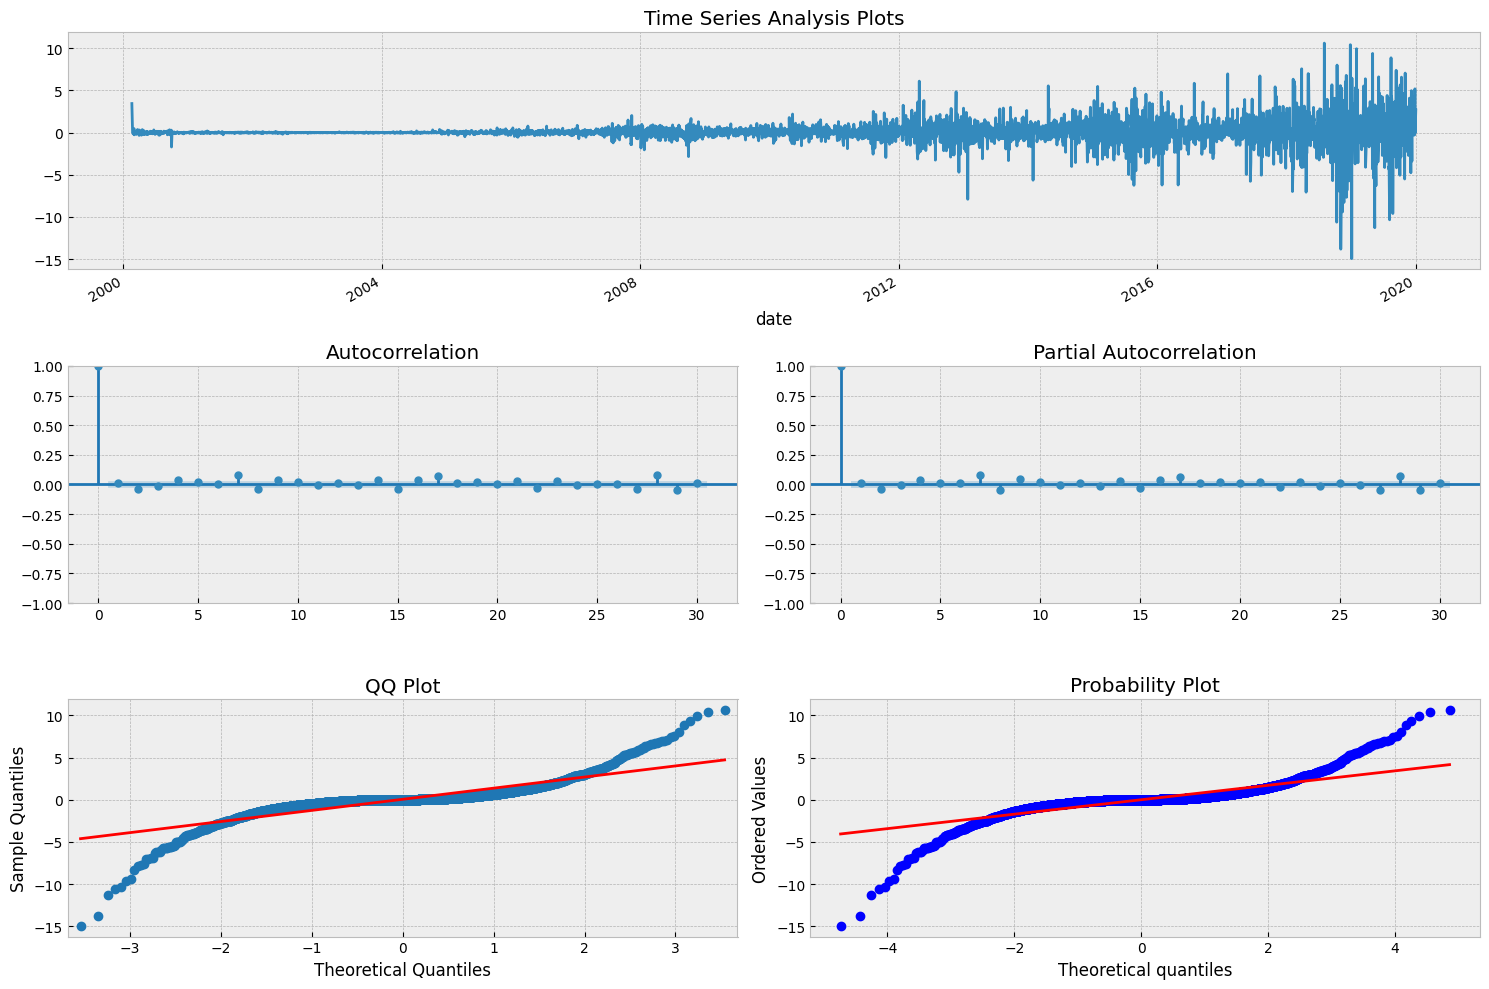

In [9]:
tsplot(best_model.resid, lags=30)

### Build the GARCH model with identified p,d,q values from above

In [11]:
import arch

In [12]:
### Derive returns from adjusted close values.
adj_close_prices = check['adj close']
returns = np.diff(np.log(adj_close_prices))


# Build a GARCH model to forecast volatility
garch_model = arch.arch_model(returns, mean='Zero', vol='GARCH', p=2, q=2)
fitted_model = garch_model.fit()
forecasted_volatility = fitted_model.forecast(horizon=1).variance.iloc[-1]

Iteration:      1,   Func. Count:      7,   Neg. LLF: 18352325.259828728
Iteration:      2,   Func. Count:     15,   Neg. LLF: -7466.241889530278
Iteration:      3,   Func. Count:     26,   Neg. LLF: 19541.090742629254
Iteration:      4,   Func. Count:     34,   Neg. LLF: -12047.967907930924
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12047.967907180151
            Iterations: 8
            Function evaluations: 34
            Gradient evaluations: 4


/Users/manikant/opt/anaconda3/envs/llm_env/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [13]:
check = assign_trading_signals(check, forecasted_volatility) 

check=check.drop_duplicates()
check=check.dropna()

/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals > sell_signals and forecasted_volatility[0] < volatility_threshold:
/var/folders/fn/t_24smz12kx0x9byvzh7mv000000gn/T/ipykernel_46771/1317240310.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


In [32]:
y_true=check['Signal'].tolist()
y_pred=check['New_Signal'].tolist()

cm = confusion_matrix(y_true, y_pred)
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
print("Precision (macro):", precision_macro)
print("Precision (per class):", precision_per_class)

# Recall
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_per_class = recall_score(y_true, y_pred, average=None)
print("Recall (macro):", recall_macro)
print("Recall (per class):", recall_per_class)

[[  29   48  309]
 [  48   68  379]
 [ 419  484 3214]]
Accuracy: 0.6624649859943977
Precision (macro): 0.3318270797624231
Precision (per class): [0.05846774 0.11333333 0.82368016]
Recall (macro): 0.33105626806923466
Recall (per class): [0.07512953 0.13737374 0.78066553]
